In [1]:
import json, requests, time, pandas as pd, matplotlib.pyplot as plt
from string import Template

In [2]:
WIKIDATA_ENDPOINT = 'https://query.wikidata.org/sparql'

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringBot/0.1 (https://github.com/bradleypallen/conceptual-engineering-using-llms; bradley.p.allen@gmail.com)'
}

CLASS_QUERY = """SELECT ?class ?classLabel ?classDescription ?classWikipediaName ?classArticle ?superclass ?superclassLabel ?superclassDescription ?superclassWikipediaName ?superclassArticle WHERE {
    ?class wdt:P279 ?superclass ;
              rdfs:label ?classLabel ;
              schema:description ?classDescription .
    ?superclass rdfs:label ?superclassLabel ;
              schema:description ?superclassDescription .
    ?classArticle schema:about ?class ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?classWikipediaName .
    ?superclassArticle schema:about ?superclass ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?superclassWikipediaName .
    FILTER(LANG(?classLabel) = "en")
    FILTER(LANG(?classDescription) = "en")
    FILTER(LANG(?superclassLabel) = "en")
    FILTER(LANG(?superclassDescription) = "en")
}
LIMIT 15000
"""

CLASS_EXTENSION_CARDINALITY_QUERY = Template("""SELECT (COUNT(?instance) AS ?count) WHERE {
    ?instance p:P31/ps:P31/wdt:P279* $class .
}
""")
                                             
MIN_CARDINALITY = 100

In [3]:
def extension_cardinality(wd_class):
    response = requests.get(WIKIDATA_ENDPOINT, params={'query' : CLASS_EXTENSION_CARDINALITY_QUERY.substitute({"class": wd_class}), 'format' : 'json'}, headers=QUERY_HEADERS)
    response.raise_for_status()
    return int(json.loads(response.text)["results"]["bindings"][0]["count"]["value"])

In [4]:
print("Getting classes...")
response = requests.get(WIKIDATA_ENDPOINT, params={'query' : CLASS_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
classes = [ { k: v["value"] for k, v in result.items() } for result in json.loads(response.text)["results"]["bindings"] ]
print(f'Retrieved {len(classes)} classes from Wikidata.')
json.dump(classes, open('benchmarks/classes.json', 'w+'))

Getting classes...
15000 retrieved from Wikidata.


In [5]:
candidates = []
print("Getting extension cardinalities...", end = " ")
for i, cls in enumerate(classes):
    time.sleep(0.250)
    try:
        count = extension_cardinality(f'wd:{cls["class"].removeprefix("http://www.wikidata.org/entity/")}')
        if count >= MIN_CARDINALITY:
            cls["count"] = count
            candidates.append(cls)
    except Exception as e:
        print(f'Exception occurred at class {cls["classLabel"]} (iteration {i}): {e}', end=" ")
        time.sleep(10)
    if i > 0 and i % 1000 == 0:
        print(f'{i}... ', end = " ")
        time.sleep(60)
print(f'Found {len(candidates)} classes with extension cardinality >= {MIN_CARDINALITY}.')
json.dump(candidates, open('benchmarks/candidates.json', 'w+'))

Getting extension cardinalities... 1000...  2000...  Exception occurred at class omnivore (iteration 2452): 500 Server Error: Internal Server Error for url: https://query.wikidata.org/sparql?query=SELECT+%28COUNT%28%3Finstance%29+AS+%3Fcount%29+WHERE+%7B%0A++++%3Finstance+p%3AP31%2Fps%3AP31%2Fwdt%3AP279%2A+wd%3AQ164509+.%0A%7D%0A&format=json 3000...  4000...  5000...  6000...  7000...  8000...  9000...  10000...  Exception occurred at class star (iteration 10615): 500 Server Error: Internal Server Error for url: https://query.wikidata.org/sparql?query=SELECT+%28COUNT%28%3Finstance%29+AS+%3Fcount%29+WHERE+%7B%0A++++%3Finstance+p%3AP31%2Fps%3AP31%2Fwdt%3AP279%2A+wd%3AQ523+.%0A%7D%0A&format=json 11000...  12000...  Exception occurred at class individual (iteration 12753): 500 Server Error: Internal Server Error for url: https://query.wikidata.org/sparql?query=SELECT+%28COUNT%28%3Finstance%29+AS+%3Fcount%29+WHERE+%7B%0A++++%3Finstance+p%3AP31%2Fps%3AP31%2Fwdt%3AP279%2A+wd%3AQ795052+.%0A%7D

In [6]:
df = pd.DataFrame.from_records(candidates).sort_values("count", ascending=False)
df_range = df[["classLabel", "classDescription", "count", "superclassLabel"]]
df_range.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})

,classLabel,classDescription,count,superclassLabel
419,fusor,astronomical object that achieves core fusion during its lifetime,4952014,astronomical object
417,deep-sky object,any astronomical object that is not an individual star,2760285,astronomical object
171,proper noun,grammatical concept,766787,noun
98,variable star,star whose brightness as seen from Earth fluctuates,737042,star
112,village,small settlements and a lower administrative level in the modern People's Republic of China and historical Chinese states,591497,village
336,astronomical radio source,object in outer space that emits strong radio waves,454259,astronomical object
127,calendar date,particular day represented within a calendar system,391602,day
408,asterism,pattern of stars recognized on Earth's night sky,389736,astronomical object
365,star system,"type of astronomical object, stars which orbit each other",344851,astronomical object
411,binary system,system of two astronomical bodies which orbit each other,344437,astronomical object


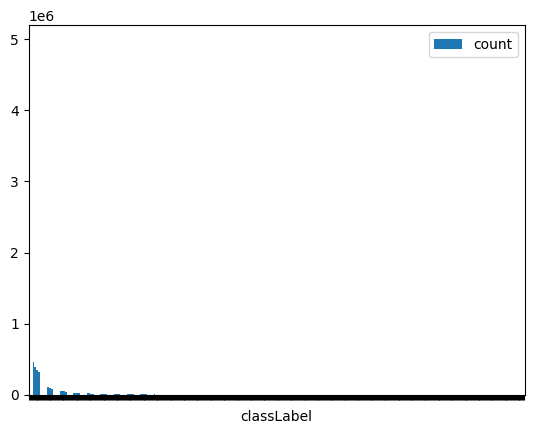

In [7]:
ax = df_range.plot.bar(x='classLabel', y='count', rot=0)
ax.set_xticklabels([])
plt.show()